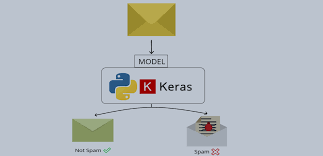

**1. What is BERT?**

**BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It stands for Bidirectional Encoder Representations for Transformers. It has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning**

**2. Why BERT?**

* BERT was built upon recent work and clever ideas in pre-training contextual representations including Semi-supervised Sequence Learning, Generative Pre-Training, ELMo, the OpenAI Transformer, ULMFit and the Transformer. Although these models are all unidirectional or shallowly bidirectional, BERT is fully bidirectional.
* BERT gives it incredible accuracy and performance on smaller data sets which solves a huge problem in natural language processing.

**3. How does it work?**

BERT relies on a Transformer (the attention mechanism that learns contextual relationships between words in a text). A basic Transformer consists of an encoder to read the text input and a decoder to produce a prediction for the task. Since BERT’s goal is to generate a language representation model, it only needs the encoder part. The input to the encoder for BERT is a sequence of tokens, which are first converted into vectors and then processed in the neural network. But before processing can start, BERT needs the input to be massaged and decorated with some extra metadata:

1. Token embeddings: A [CLS] token is added to the input word tokens at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. Segment embeddings: A marker indicating Sentence A or Sentence B is added to each token. This allows the encoder to distinguish between sentences.
3. Positional embeddings: A positional embedding is added to each token to indicate its position in the sentence.

**4. How to use BERT?**

**BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model**

1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.

2. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.

3. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.

**Import Libraries and Data** 

In [1]:
import numpy as np 
import pandas as pd
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'tokenization'

In [2]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BERT_project/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BERT_project/Corona_NLP_test.csv', encoding='latin-1')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/BERT_project/Corona_NLP_train.csv'

In [5]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


**Label encoding of labels**

In [7]:
label = preprocessing.LabelEncoder()
y = label.fit_transform(train_data['Sentiment'])
y = to_categorical(y)
print(y[:5])

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


**Build a BERT layer**

we create a BERT embedding layer by importing the BERT model from hub.KerasLayer

In [8]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

**Encoding the text**

we create a BERT vocab_file in the form a numpy array. We then set the text to lowercase and finally we pass our vocab_file and do_lower_case variables to the Tokenizer object.

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

**Build The Model**

Now we are all set to create our model. To do so, we will create a function named build_model that having tf.keras.models.Model class. Inside the function we will define our model layers. Our model will consist of three **Dense** neural network layers and also dropout layer. We have chosen a learning rate to 1e-5.

**RELU function** :- 
With default values, this returns max(x, 0), the element-wise maximum of 0 and the input tensor.
Modifying default parameters allows you to use non-zero thresholds, change the max value of the activation, and to use a non-zero multiple of the input for values below the threshold.


**Softmax function** :-
Softmax converts a real vector to a vector of categorical probabilities.
The elements of the output vector are in range (0, 1) and sum to 1.
Each vector is handled independently. The axis argument sets which axis of the input the function is applied along.
Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution.
The softmax of each vector x is computed as exp(x) / tf.reduce_sum(exp(x)).

**Binary corssentropy**:-
Computes the cross-entropy loss between true labels and predicted labels.
We can use this cross-entropy loss when there are only two label classes (assumed to be 0 and 1). For each example, there should be a single floating-point value per prediction.

In [10]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(5, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Here We check only the first 250 characters of each text, and also we set train-test input and train labels

In [11]:
max_len = 250
train_input = bert_encode(train_data.OriginalTweet.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.OriginalTweet.values, tokenizer, max_len=max_len)
train_labels = y

In [12]:
labels = label.classes_
print(labels)

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


In [13]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

**Run the model**

In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/3
1029/1029 [==============================] - ETA: 0s - loss: 1.1575 - accuracy: 0.5183
Epoch 00001: val_accuracy improved from -inf to 0.79470, saving model to model.h5
1029/1029 [==============================] - 1057s 1s/step - loss: 1.1575 - accuracy: 0.5183 - val_loss: 0.5773 - val_accuracy: 0.7947
Epoch 2/3
1029/1029 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7884
Epoch 00002: val_accuracy improved from 0.79470 to 0.82908, saving model to model.h5
1029/1029 [==============================] - 1057s 1s/step - loss: 0.6357 - accuracy: 0.7884 - val_loss: 0.4788 - val_accuracy: 0.8291
Epoch 3/3
1029/1029 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8624
Epoch 00003: val_accuracy improved from 0.82908 to 0.86334, saving model to model.h5
1029/1029 [==============================] - 1058s 1s/step - loss: 0.4301 - accuracy: 0.8624 - val_loss: 0.4275 - val_accuracy: 0.8633
